In [44]:
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import string
import codecs
import re
import os.path
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score,f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Biliothèques pour échantillonner

In [45]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Initialisation mon Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M1_S2/RITAL/Projet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/M1_S2/RITAL/Projet


# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [ ]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

def load_pres_test(fname):
    alltxts = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        alltxts.append(txt)
    return alltxts

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts_president,alllabs_president = load_pres(fname)
alllabs_president = np.asarray(alllabs_president)

In [ ]:
print(len(alltxts_president),len(alllabs_president))
print(alltxts_president[0])
print(alllabs_president[0])
print(alltxts_president[-1])
print(alllabs_president[-1])



57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


# Données classification de sentiments (films)

In [47]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        #print(cl)
        for f in os.listdir(path2data+cl):
            if f != '.ipynb_checkpoints':
                txt = open(path2data+cl+'/'+f).read()
                alltxts.append(txt)
                labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [48]:
path = "./datasets/movies/movies1000/"

alltxts_film,alllabs_film = load_movies(path)

In [ ]:
print(len(alltxts_film),len(alllabs_film))
print(alltxts_film[0])
print(alllabs_film[0])
print(alltxts_film[-1])
print(alllabs_film[-1])

2000 2000
maybe this mission should have been scrubbed 
mission to mars 
a film review by michael redman copyright 2000 by michael redman 
there's a world of difference between artists and technicians . 
the artist has a vision to create something new . 
he may not do it well , it might be sloppy , but it's something you've never seen before . 
a good technician can make it look good , but without direction from his own inner artist or someone else , it's going to be just a xerox . 
obviously successful films need both skills . 
brian de palma is a masterful technician . 
he's spent his career copying others , most notably hitchcock . 
he usually knows exactly what to do to make a scene work , but only because he has learned it by rote . 
aside from rare flashes of originality , his films are often soul-dead . 
in de palma's latest , he turns his attention to stanley kubrick . 
to tell the truth , i enjoyed portions of this movie , but i liked it a lot better over 30 years ago when it 

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [ ]:
stopwords_en = stopwords.words('english')
stopwords_fr = stopwords.words('french')
stopwords_fr.append("cette")
stopwords_en_fr = stopwords.words('english') + stopwords.words('french')

In [ ]:
## liste des pays sauf France
l_pays = ["Afghanistan", "Afrique du Sud", "Albanie", "Algérie", "Allemagne", "Andorre", "Angola", "Antigua-et-Barbuda", "Arabie saoudite", "Argentine", "Arménie", "Australie", "Autriche", "Azerbaïdjan", "Bahamas", "Bahreïn", "Bangladesh", "Barbade", "Belgique", "Belize", "Bénin", "Bhoutan", "Biélorussie", "Birmanie", "Bolivie", "Bosnie-Herzégovine", "Botswana", "Brésil", "Brunei", "Bulgarie", "Burkina Faso", "Burundi", "Cambodge", "Cameroun", "Canada", "Cap-Vert", "République centrafricaine", "Chili", "Chine", "Chypre", "Colombie", "Comores", "République du Congo", "République démocratique du Congo", "Îles Cook", "Corée du Nord", "Corée du Sud", "Costa Rica", "Côte d'Ivoire", "Croatie", "Cuba", "Danemark", "Djibouti", "République dominicaine", "Dominique", "Égypte", "Émirats arabes unis", "Équateur", "Érythrée", "Espagne", "Estonie", "États-Unis", "Éthiopie", "Fidji", "Finlande", "Gabon", "Gambie", "Géorgie", "Ghana", "Grèce", "Grenade", "Guatemala", "Guinée", "Guinée-Bissau", "Guinée équatoriale", "Guyana", "Haïti", "Honduras", "Hongrie", "Inde", "Indonésie", "Irak", "Iran", "Irlande", "Islande", "Israël", "Italie", "Jamaïque", "Japon", "Jordanie", "Kazakhstan", "Kenya", "Kirghizistan", "Kiribati", "Koweït", "Laos", "Lesotho", "Lettonie", "Liban", "Liberia", "Libye", "Liechtenstein", "Lituanie", "Luxembourg", "Macédoine", "Madagascar", "Malaisie", "Malawi", "Maldives", "Mali", "Malte", "Îles Marshall", "Maurice", "Mauritanie", "Mexique", "Micronésie", "Moldavie", "Monaco", "Mongolie", "Monténégro", "Maroc", "Mozambique", "Namibie", "Nauru", "Népal", "Nicaragua", "Niger", "Nigeria", "Niue", "Norvège", "Nouvelle-Zélande", "Oman", "Ouganda", "Ouzbékistan", "Pakistan", "Palaos", "Palestine", "Panama", "Papouasie-Nouvelle-Guinée",
"Paraguay","Pays-Bas","Pérou","Philippines","Pologne","Portugal","Qatar","Roumanie","Royaume-Uni","Russie","Rwanda","Saint-Christophe-et-Niévès","Sainte-Lucie","Saint-Marin",
"Saint-Vincent-et-les Grenadines","Îles Salomon","Salvador","Samoa","Sao Tomé-et-Principe","Sénégal","Serbie","Seychelles","Sierra Leone","Singapour","Slovaquie","Slovénie","Somalie",
"Soudan","Soudan du Sud","Sri Lanka","Suède","Suisse","Suriname","Swaziland","Syrie","Tadjikistan","Tanzanie","Tchad","République tchèque","Thaïlande","Timor oriental","Togo",
"Tonga","Trinité-et-Tobago","Tunisie","Turkménistan","Turquie","Tuvalu","Ukraine","Uruguay","Vanuatu","Vatican","Venezuela","Viêt Nam","Yémen","Zambie","Zimbabwe"]
l_pays = [p.lower() for p in l_pays]

In [ ]:
def prepretraiter_corpus(corpus, lower=True, ponctuation=True, stop_word = None, enleve_accent=True, marqueur=True, sup_chiffre=True, stem=None):
  corpus_res = []
  for doc in corpus:
    if lower:
      doc=doc.lower()
    if ponctuation:
      punc = string.punctuation + '\n\r\t'
      doc = doc.translate(str.maketrans(punc, ' '*len(punc)))
    if marqueur:
      for pays in l_pays:
        doc = doc.replace(pays, "NOMPAYS")
      doc = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', doc)
    if sup_chiffre:
      doc = re.sub('[0-9]+', '', doc)
    if stop_word is not None:
      doc = word_tokenize(doc)
      doc = ' '.join([w for w in doc if w not in stop_word])
    if enleve_accent:
      doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
    if stem is not None:
      doc = word_tokenize(doc)
      doc = ' '.join([stem.stem(w) for w in doc])
    corpus_res.append(doc)
  return corpus_res


In [ ]:
# Test lower
test = alltxts_president[0]
prepretraiter_corpus([test], lower=True,ponctuation=False, enleve_accent=False, marqueur=False, sup_chiffre=False, stem=None)

[" quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n"]

In [ ]:
# Test ponctuation suppression
test = alltxts_president[0]
prepretraiter_corpus([test], lower=False,ponctuation=True, enleve_accent=False, marqueur=False, sup_chiffre=False, stem=None)

[' Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  ']

In [ ]:
# Test stopword
test = alltxts_president[0]
prepretraiter_corpus([test], lower=True,ponctuation=True, stop_word = stopwords_fr, enleve_accent=False, marqueur=False, sup_chiffre=False, stem=None)

['quand dis chers amis agit là formule diplomatique expression ressens']

In [ ]:
# Test accents suppression
test = alltxts_president[0]
prepretraiter_corpus([test], lower=False,ponctuation=False, enleve_accent=True, marqueur=False, sup_chiffre=False, stem=None)

[" Quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.\n"]

In [ ]:
# Test stemming
stemmer = SnowballStemmer("french")
test = alltxts_president[0]
prepretraiter_corpus([test], lower=True,ponctuation=True, enleve_accent=True, marqueur=True, sup_chiffre=True, stem=stemmer)

['quand je dis cher amis il ne s agit pas la d une formul diplomat mais de l express de ce que je ressen']

In [ ]:
# Test suppression de chiffres
test = "Bonjour, j'ai 23 ans. Mon site web est www.bob.fr"
prepretraiter_corpus([test], lower=False,ponctuation=False, enleve_accent=False, marqueur=False, sup_chiffre=True, stem=None)

["Bonjour, j'ai  ans. Mon site web est www.bob.fr"]

In [ ]:
# Test marqueur
test = "Bonjour, j'ai 23 ans. Mon site web est www.bob.fr"
prepretraiter_corpus([test], lower=False,ponctuation=False, enleve_accent=False, marqueur=True, sup_chiffre=False, stem=None)

["Bonjour, j'ai 23 ans. Mon site web est URL"]

In [ ]:
alllabs_president = np.asarray(alllabs_president)
inx_neg = np.where(alllabs_president == -1)[0]
inx_pos = np.where(alllabs_president == +1)[0]

print("Tester sur classe negative:\n", prepretraiter_corpus([alltxts_president[inx_neg[0]]],stop_word = stopwords_fr, stem=stemmer))
print("Tester sur classe positve:\n", prepretraiter_corpus([alltxts_president[inx_pos[0]]],stop_word = stopwords_fr, stem=stemmer))

Tester sur classe negative:
 ['sais ni pourquoi ni comment oppos a quelqu douz anne douz treiz an creation universit technolog']
Tester sur classe positve:
 ['quand dis cher amis agit la formul diplomat express ressen']


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

# Reconnaissance du locuteur (Chirac/Mitterrand)
Consultons la distribution des classes pour ce jeu de données

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts_president,alllabs_president = load_pres(fname)
alllabs_president = np.asarray(alllabs_president)

## Première vue sur les données

In [ ]:
stopwords_en = stopwords.words('english')
stopwords_fr = stopwords.words('french')
stopwords_fr.append("cette")
stopwords_en_fr = stopwords.words('english') + stopwords.words('french')

In [ ]:
stemmer = SnowballStemmer("french")
corpus_traite=prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr, stem=stemmer)
## BoW par defaut
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_traite)

print("Taille du dictionnaire :", len(vectorizer.get_feature_names_out()))

Taille du dictionnaire : 13826


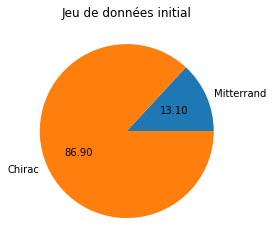

In [ ]:
count = Counter(alllabs_president)
nb_electif = np.array([count[-1], count[+1]])
plt.pie(nb_electif,labels=["Mitterrand", "Chirac"], autopct="%.2f")
plt.title("Jeu de données initial")
plt.show()

In [ ]:
## N-gram
tab_nom_ = ["Uni et bi-gram", "bi-gram", "tri-gram","uni-bi-tri-gram"]
tab_ngram = [(1,2), (2,2), (3,3),(1,3)]
tab_X_ngram = []
tab_vec_ngram = []
# creation 
for choix in tab_ngram:
  vectorizer_ngram = CountVectorizer(ngram_range=choix)
  X_ngram = vectorizer_ngram.fit_transform(corpus_traite)
  # ajoutation
  tab_vec_ngram.append(vectorizer_ngram)
  tab_X_ngram.append(X_ngram)
for i in range(len(tab_nom_)):
  print(f"Taille du dictionnaire pour {tab_nom_[i]} :", len(tab_vec_ngram[i].get_feature_names_out()))

Taille du dictionnaire pour Uni et bi-gram : 349415
Taille du dictionnaire pour bi-gram : 335589
Taille du dictionnaire pour tri-gram : 501438
Taille du dictionnaire pour uni-bi-tri-gram : 850853


Nous pouvons voir que la taille du dictionnaire augmente exponentiellement

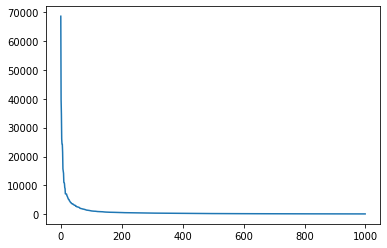

In [ ]:
stopwords_fr = stopwords.words('french')
stopwords_fr.append("cette")

corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
corpus = ''.join(alltxts_president)
word = corpus.split()
cpt = Counter(word)
nb_occ = [f for w,f in cpt.most_common(1000)]
plt.plot(nb_occ)

Nous voyons que la distribution suit bien la loi de Zipf</br>
Nous allons visualiser les données avec WordCloud

(-0.5, 399.5, 199.5, -0.5)

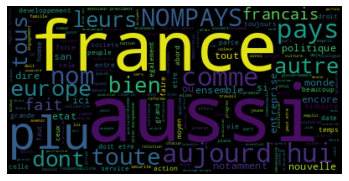

In [ ]:
from wordcloud import WordCloud
corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
corpus = ''.join(corpus)

wordcloud = WordCloud().generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Nous affichons les 100 mots les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

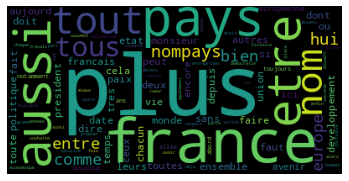

In [ ]:
vectorizer_tmp = CountVectorizer(max_df=0.95)
corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
X = vectorizer_tmp.fit_transform(corpus)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Les 100 mots dont la fréquence documentaire est la plus grande

(-0.5, 399.5, 199.5, -0.5)

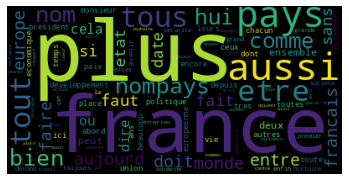

In [ ]:
vectorizer_tmp = CountVectorizer(max_df=0.95,binary=True) # binary = True, on met 1 au lieu du nombre d'occurence
corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
X = vectorizer_tmp.fit_transform(corpus)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Nous affichons les 100 bi-gramme les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

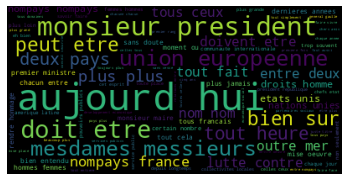

In [ ]:
vectorizer_tmp = CountVectorizer(ngram_range=(2,2),max_df=0.95)
corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
X = vectorizer_tmp.fit_transform(corpus)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Et les 100 tri-gramme les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

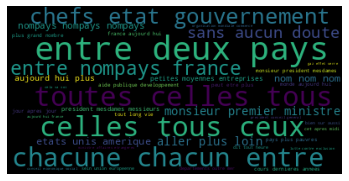

In [ ]:
vectorizer_tmp = CountVectorizer(ngram_range=(3,3),max_df=0.95)
corpus = prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr)
X = vectorizer_tmp.fit_transform(corpus)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Traiter les données pour l'apprentissage

In [ ]:
stemmer = SnowballStemmer("french")
corpus_traite=prepretraiter_corpus(alltxts_president,stop_word = stopwords_fr, stem=stemmer)

In [ ]:
count = Counter(alllabs_president)
count

Counter({1: 49890, -1: 7523})

In [ ]:
count[-1]/count[1]

0.15079174183203048

Nous remarquons que notre base de données pour l'apprentissage est très déséquilibrée. Le ratio entre les 2 classes sont 15:85.</br>
Nous allons faire la validation croissée et split test sur les données avant et après d'avoir réglé le déséquilibre des donnés pour voir les impacts de la distribution de classes sur la performance des modèles.

## Les classifieurs utilisés

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

tab_clf_nom = ["Naïve Bayes","Logistic Regression","Linear SVM" ]
#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

tab_clf = [nb_clf, lr_clf,svm_clf]

## KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

score_nb_kf = np.array([])
score_lr_kf = np.array([])
score_svm_kf = np.array([])



for k in range(5, 12):
  kf = KFold(n_splits=k, shuffle=True)

  score_nb = np.array([])
  score_lr = np.array([])
  score_svm = np.array([])

  for train, test in kf.split(X):
      X_train = X[train]
      y_train = alllabs_president[train]
      X_test  = X[test]
      y_test  = alllabs_president[test]
      # training
      nb_clf.fit(X_train, y_train)
      lr_clf.fit(X_train, y_train)
      svm_clf.fit(X_train, y_train)
      # prediction
      y_pred_nb = nb_clf.predict(X_test)
      y_pred_lr = lr_clf.predict(X_test)
      y_pred_svm = svm_clf.predict(X_test)
      # evaluation
      score_nb = np.append(score_nb, accuracy_score(y_test, y_pred_nb))
      score_lr = np.append(score_lr, accuracy_score(y_test, y_pred_lr))
      score_svm = np.append(score_svm, accuracy_score(y_test, y_pred_svm))

  score_nb_kf = np.append(score_nb_kf, score_nb.mean())
  score_lr_kf = np.append(score_lr_kf, score_lr.mean())
  score_svm_kf = np.append(score_svm_kf, score_svm.mean())

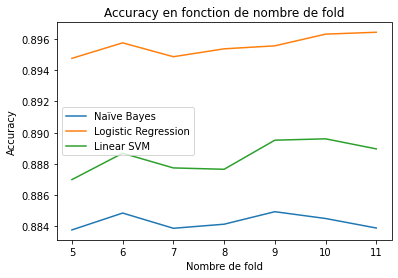

In [ ]:
# Sur les valeurs de fold différentes
tab_k = np.arange(5, 12)

plt.figure()
plt.plot(tab_k, score_nb_kf)
plt.plot(tab_k, score_lr_kf)
plt.plot(tab_k, score_svm_kf)
plt.legend(["Naïve Bayes", "Logistic Regression","Linear SVM"])
plt.ylabel('Accuracy')
plt.xlabel('Nombre de fold')
plt.title('Accuracy en fonction de nombre de fold')
plt.show()

Les accuracy des modèles semblent stables pour k de 5 à 11

## Split test 20%

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_president, test_size=0.3, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

# evaluation
print("F1-score Naïve Bayes:", f1_score(y_test, y_pred_nb))
print("F1-score Logistic Regression:", f1_score(y_test, y_pred_lr))
print("F1-score Linear SVM:", f1_score(y_test, y_pred_svm))

F1-score Naïve Bayes: 0.9359808956786286
F1-score Logistic Regression: 0.9420313153072051
F1-score Linear SVM: 0.9351691735456296


Nous obtenons la même performance avec split et K-Fold.</br>
La validation croissée reste nécessaire car elle permet de s'assurer que toutes les classes du jeu de données sont représentées dans les ensembles d'entraînement et de test, ce qui peut améliorer la robustesse et la généralisation du modèle.

## ROC, AUC, F1 score

In [53]:
def ROC(y_test, y_pred):
  # Calculer la courbe ROC
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)

  # F1 score
  print("F1 score:", f1_score(y_test, y_pred)) 

  # Calculer l'aire sous la courbe ROC (AUC)
  roc_auc = auc(fpr, tpr)

  # Tracer la courbe ROC
  plt.plot(fpr, tpr, lw=1, alpha=0.8,
          label='Courbe ROC (AUC = %0.2f)' % roc_auc)

  # Tracer la ligne diagonale pour la référence
  plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', alpha=.8)

  # Paramètres de la figure
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Taux de faux positifs')
  plt.ylabel('Taux de vrais positifs')
  plt.legend(loc="lower right")

  # Afficher la figure
  plt.show()

F1 score: 0.9359808956786286


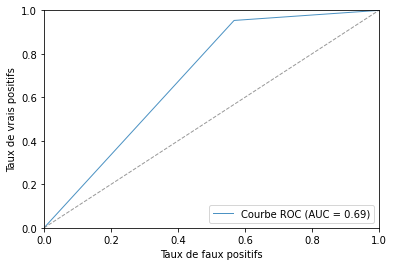

In [ ]:
# Naïve Bayes
ROC(y_test,y_pred_nb)

F1 score: 0.9420313153072051


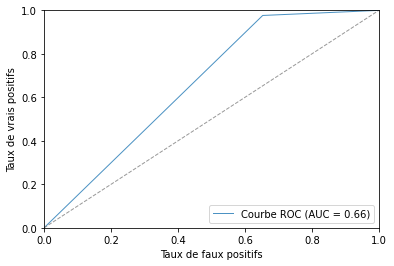

In [ ]:
# Logistic Regression
ROC(y_test,y_pred_lr)

F1 score: 0.9351691735456296


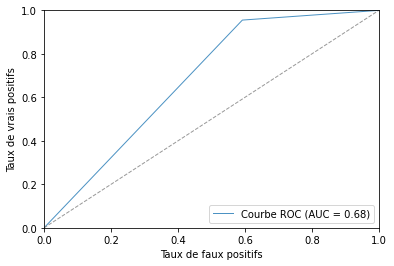

In [ ]:
# SVM
ROC(y_test,y_pred_svm)

<h2>Analyse</h2>
En analysant les ROC, il semble que Naïve Bayes et SVM sont un peu meilleurs que Logistic Regression. Mais AUC de Naïve Bayes (0.69) est supérieur que AUC de SVM (0.68). Par contre, Logistic Regression a le meilleur F1-score.</br>
Dans notre cas, Naïve Bayes et SVM sont meilleurs pour la distinction entre les classes, ce qui est important si la distribution des classes est déséquilibrée.

On applique sur les données test pour évaluer la performance, nous allons utiliser Logistic Regression car son f1-score est le meilleur entre 3 modèles

In [ ]:
fname_test = "./datasets/AFDpresidentutf8/corpus.tache1.test.utf8"
alltxts_president_test = load_pres_test(fname_test)

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = vectorizer.transform(corpus_traite_test)

In [ ]:
# Logistic Regression
lr_clf.fit(X, alllabs_president)
y_hat = lr_clf.predict(X_test)
# M -1, C 1
with open("f_eval_lr.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


## Résultat
Pour Logistic Regression, nous obtenons f1-score: 46.6537, auc: 66.2290</br>
Avec un tel déséquilibre dans la base de données, nous avons prévu que les modèles généralisent mal sur les données test et le résultat y correspond. Nous essayons de régler le déséquilibre.

## Variants de BoW

In [54]:
def cv_kfold(X, Y, modele, tab_nom_,nb_splits=6,shuffle=True,affiche=True):
  n = len(modele)
  tab_score = []
  tab_f1 = []
  tab_auc = []

  kf = KFold(n_splits=nb_splits, shuffle=shuffle)

  for train, test in kf.split(X):
    X_train = X[train]
    y_train = Y[train]
    X_test  = X[test]
    y_test  = Y[test]
    # training
    for i in range(len(modele)):
      modele[i].fit(X_train, y_train)
    # prediction
    tab_y_pred = []
    for i in range(len(modele)):
      tab_y_pred.append(modele[i].predict(X_test))
    # evaluation
    for i in range(len(modele)):
      # acc
      tab_score.append(accuracy_score(y_test, tab_y_pred[i]))
      # f1
      tab_f1.append(f1_score(y_test, tab_y_pred[i]))
      # auc
      fpr, tpr, _ = roc_curve(y_test, tab_y_pred[i])
      roc_auc = auc(fpr, tpr)
      tab_auc.append(roc_auc)

  tab_score = np.asarray(tab_score)
  tab_f1 = np.asarray(tab_f1)
  tab_auc = np.asarray(tab_auc)
  if affiche:
    for i in range(len(modele)):
      print(tab_nom_[i])
      print("Accuracy:", tab_score[i].mean())
      print("F1 score:", tab_f1[i].mean())
      print("AUC:", tab_auc[i].mean())
  if not affiche and len(modele) == 1: #si non affichage et le nombre de classifieur =1, on recuppere les donnnees
    return np.array([tab_score[0].mean(), tab_f1[0].mean(), tab_auc[0].mean()])


In [ ]:
import time

for i in range(len(tab_X_ngram)):
  start = time.time()
  print(f"{tab_nom_[i]}")
  cv_kfold(tab_X_ngram[i], alllabs_president,tab_clf,tab_clf_nom)
  end = time.time()
  print("Cela prend",end - start)
  print("\n")

Uni et bi-gram
Naïve Bayes
Accuracy: 0.8901661615633818
F1 score: 0.9390759955944582
AUC: 0.652506865142824
Logistic Regression
Accuracy: 0.9031246734246002
F1 score: 0.9463386396526773
AUC: 0.6766353224374732
Linear SVM
Accuracy: 0.8969589298777302
F1 score: 0.9423526660430309
AUC: 0.6917358395821729
Cela prend 120.50414490699768


bi-gram
Naïve Bayes
Accuracy: 0.7926638102205037
F1 score: 0.8726572528883184
AUC: 0.7108623943324285
Logistic Regression
Accuracy: 0.8762671125509458
F1 score: 0.9328112586539553
AUC: 0.5610100517929006
Linear SVM
Accuracy: 0.8778346744696416
F1 score: 0.9328662493539309
AUC: 0.5976865923674435
Cela prend 66.256178855896


tri-gram
Naïve Bayes
Accuracy: 0.4693280384575191
F1 score: 0.5861450692746536
AUC: 0.5778236469264595
Logistic Regression
Accuracy: 0.8713554185390323
F1 score: 0.9311790685973054
AUC: 0.5037452954428857
Linear SVM
Accuracy: 0.8710419061552931
F1 score: 0.9308838355550577
AUC: 0.5087332134062061
Cela prend 79.50220012664795




## Custom Vectorizer
Joueur avec des paramètres

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                            max_df=0.8, min_df=1,
                             max_features=200000,
                             binary=False)
mon_X = mon_vectorizer.fit_transform(corpus_traite)
print("Taille du dictionnaire :", len(mon_vectorizer.get_feature_names_out()))

custom_tab_clf_nom = ["Logistic Regression"]

#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

custom_tab_clf = [lr_clf]
# CV
cv_kfold(mon_X, alllabs_president,custom_tab_clf,custom_tab_clf_nom)

Taille du dictionnaire : 200000
Logistic Regression
Accuracy: 0.9004075660988609
F1 score: 0.9446348689943647
AUC: 0.6796346614023503


# Ré-équilibrer le jeu de données
Nous regardons la distribution pour la base de données initiale.

## Random Oversampling
Nous essayons de monter le nombre d'exemple de la classe minoritaire

### Méthode normal

Counter({1: 49890, -1: 49890})


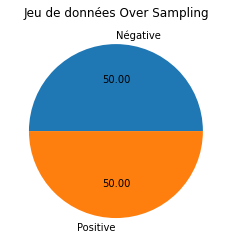

In [ ]:
ros = RandomOverSampler(sampling_strategy=1) # minor = maj, incrementer minor
X_res, lab_res = ros.fit_resample(X, alllabs_president)

count = Counter(lab_res)
print(count)
nb_electif = np.array([count[-1], count[+1]])
plt.pie(nb_electif,labels=["Négative", "Positive"], autopct="%.2f")
plt.title("Jeu de données Over Sampling")
plt.show()

Testons avec split test

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X_res, lab_res, test_size=0.3, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)

# evaluation
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

Naïve Bayes
Accuracy: 0.8246809647892029
F1-score: 0.8226307962687576
Logistic Regression
Accuracy: 0.8589229638538117
F1-score: 0.857393712220984


F1 score: 0.8226307962687576


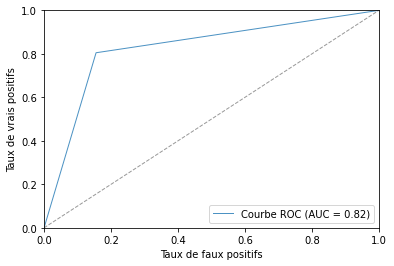

In [ ]:
# Naïve Bayes
ROC(y_test,y_pred_nb)

F1 score: 0.857393712220984


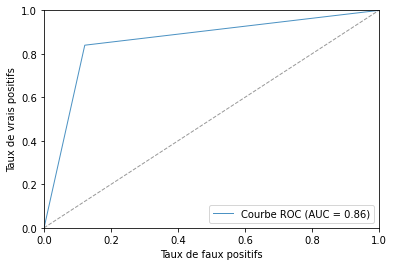

In [ ]:
# Logistic Regression
ROC(y_test,y_pred_lr)

Nous remarquons une augmentation pour ROC et AUC.</br>
Par contre, F1-score a baissé.</br>
Nous testons sur les données test pour voir la différence.

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = vectorizer.transform(corpus_traite_test)

In [ ]:
#Logistic Regression
lr_clf.fit(X_res, lab_res)
y_hat = lr_clf.predict(X_test)
# M -1, C 1
with open("f_eval_lr_oversampling.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


**Résultat**
Pour Logistic Regression, nous obtenons f1-score: 51.0147, auc: 75.6919</br>
La performance est meilleure. Par contre, f1-score est très faible, on n'as pas trop augmenté ce score.

### SMOTE
Nous voulons générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques

#### Uni_bi_gramme

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts_president,alllabs_president = load_pres(fname)
alllabs_president = np.asarray(alllabs_president)

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                            max_df=0.8, min_df=1,
                             max_features=200000,
                             binary=False)
mon_X = mon_vectorizer.fit_transform(corpus_traite)

In [ ]:
from imblearn.over_sampling import SMOTE

# Définition de l'instance SMOTE
sm = SMOTE(k_neighbors=3, sampling_strategy=0.75)

# Application du SMOTE aux données
X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)

Counter({1: 49890, -1: 37417})


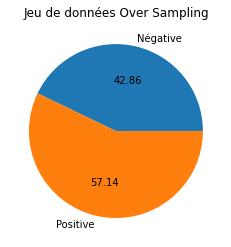

In [ ]:
count = Counter(lab_res)
print(count)
nb_electif = np.array([count[-1], count[+1]])
plt.pie(nb_electif,labels=["Négative", "Positive"], autopct="%.2f")
plt.title("Jeu de données Over Sampling")
plt.show()

In [ ]:
custom_tab_clf_nom = ["Logistic Regression"]

#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

custom_tab_clf = [lr_clf]
# CV
cv_kfold(X_res, lab_res,custom_tab_clf,custom_tab_clf_nom)

Logistic Regression
Accuracy: 0.877473886750962
F1 score: 0.8886112325857437
AUC: 0.879686738923075


In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X_res, lab_res, test_size=0.3, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)

# evaluation
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

Naïve Bayes
Accuracy: 0.6783873554002978
F1-score: 0.7663375124819706
Logistic Regression
Accuracy: 0.8760737601649295
F1-score: 0.8880226300538153


F1 score: 0.7663375124819706


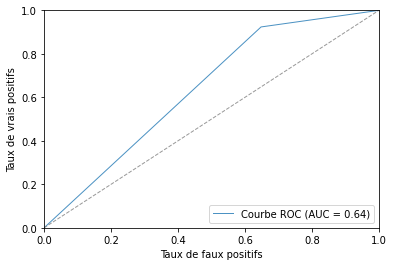

F1 score: 0.8880226300538153


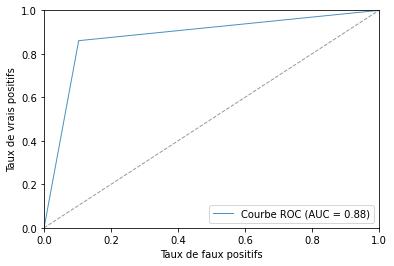

In [ ]:
# Naïve Bayes
ROC(y_test,y_pred_nb)
# Logistic Regression
ROC(y_test,y_pred_lr)

#### Uni_bi_tri_gramme

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts_president,alllabs_president = load_pres(fname)
alllabs_president = np.asarray(alllabs_president)

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                            max_df=1., min_df=1,
                             max_features=200000,
                             binary=False)
mon_X = mon_vectorizer.fit_transform(corpus_traite)

In [ ]:
# Définition de l'instance SMOTE
sm = SMOTE(k_neighbors=4, sampling_strategy=0.75)

# Application du SMOTE aux données
X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)

Counter({1: 49890, -1: 37417})


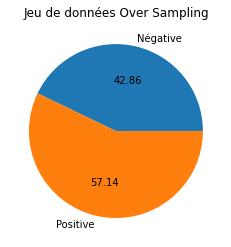

In [ ]:
count = Counter(lab_res)
print(count)
nb_electif = np.array([count[-1], count[+1]])
plt.pie(nb_electif,labels=["Négative", "Positive"], autopct="%.2f")
plt.title("Jeu de données Over Sampling")
plt.show()

In [ ]:
custom_tab_clf_nom = ["Logistic Regression"]

#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

custom_tab_clf = [lr_clf]
# CV
cv_kfold(X_res, lab_res,custom_tab_clf,custom_tab_clf_nom)

Logistic Regression
Accuracy: 0.8852391423859264
F1 score: 0.8957553058676655
AUC: 0.8879717780261189


#### KFold

In [ ]:
t_k = [i for i in range(3,8)]
t_acc= np.array([])
t_f1= np.array([])
t_auc = np.array([])

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
custom_tab_clf = [lr_clf]
custom_tab_clf_nom = ["Logistic Regression"]

mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=200000,
                                binary=False)

for k in t_k:
  sm = SMOTE(k_neighbors=k, sampling_strategy=0.75)

  # Application du SMOTE aux données
  X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)
  res = cv_kfold(X_res, lab_res, custom_tab_clf, custom_tab_clf_nom,nb_splits=6,shuffle=True,affiche=False)
  t_acc= np.append(t_acc, res[0])
  t_f1= np.append(t_f1,res[1])
  t_auc = np.append(t_auc,res[2])

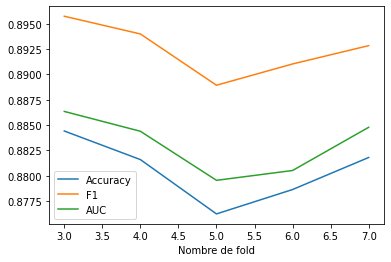

In [ ]:
plt.figure()
plt.plot(t_k, t_acc)
plt.plot(t_k, t_f1)
plt.plot(t_k, t_auc)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de k')
plt.show()

In [ ]:
## Sur sampling_strategy
t_s = np.arange(0.5, 0.85, 0.05)
t_acc= np.array([])
t_f1= np.array([])
t_auc = np.array([])

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
custom_tab_clf = [lr_clf]
custom_tab_clf_nom = ["Logistic Regression"]

mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=200000,
                                binary=False)

for s in t_s:
  sm = SMOTE(k_neighbors=3, sampling_strategy=s)

  # Application du SMOTE aux données
  X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)
  res = cv_kfold(X_res, lab_res, custom_tab_clf, custom_tab_clf_nom,nb_splits=6,shuffle=True,affiche=False)
  t_acc= np.append(t_acc, res[0])
  t_f1= np.append(t_f1,res[1])
  t_auc = np.append(t_auc,res[2])

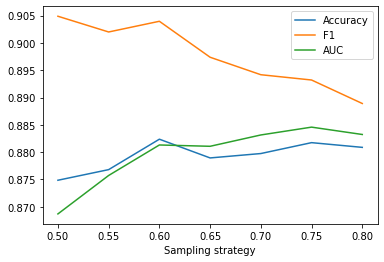

In [ ]:
plt.figure()
plt.plot(t_s, t_acc)
plt.plot(t_s, t_f1)
plt.plot(t_s, t_auc)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Sampling strategy')
plt.show()

In [ ]:
## Max feature
t_mf = [100000, 200000, 300000, None]
t_acc= np.array([])
t_f1= np.array([])
t_auc = np.array([])

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
custom_tab_clf = [lr_clf]
custom_tab_clf_nom = ["Logistic Regression"]


for mf in t_mf:
  mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=mf,
                                binary=False)
  mon_X = mon_vectorizer.fit_transform(corpus_traite)
  sm = SMOTE(k_neighbors=3, sampling_strategy=0.6)

  # Application du SMOTE aux données
  X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)
  res = cv_kfold(X_res, lab_res, custom_tab_clf, custom_tab_clf_nom,nb_splits=6,shuffle=True,affiche=False)
  t_acc= np.append(t_acc, res[0])
  t_f1= np.append(t_f1,res[1])
  t_auc = np.append(t_auc,res[2])

In [ ]:
print("Taille du dictionnaire :", len(mon_vectorizer.get_feature_names_out()))

Taille du dictionnaire : 858471


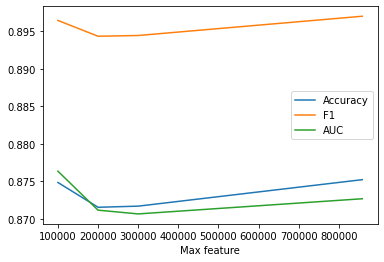

In [ ]:
t_mf = [100000, 200000, 300000, 858471]
plt.figure()
plt.plot(t_mf, t_acc)
plt.plot(t_mf, t_f1)
plt.plot(t_mf, t_auc)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Max feature')
plt.show()

In [ ]:
## Sur n-gramme
ngrame = [(1,1), (1,2),(1,3), (2,2),(2,3),(3,3)]
t_acc= np.array([])
t_f1= np.array([])
t_auc = np.array([])

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
custom_tab_clf = [lr_clf]
custom_tab_clf_nom = ["Logistic Regression"]



for ng in ngrame:
  mon_vectorizer = CountVectorizer(ngram_range=ng,
                                max_df=1., min_df=1,
                                max_features=100000,
                                binary=False)
  mon_X = mon_vectorizer.fit_transform(corpus_traite)
  sm = SMOTE(k_neighbors=3, sampling_strategy=0.6)

  # Application du SMOTE aux données
  X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)
  res = cv_kfold(X_res, lab_res, custom_tab_clf, custom_tab_clf_nom,nb_splits=6,shuffle=True,affiche=False)
  t_acc= np.append(t_acc, res[0])
  t_f1= np.append(t_f1,res[1])
  t_auc = np.append(t_auc,res[2])

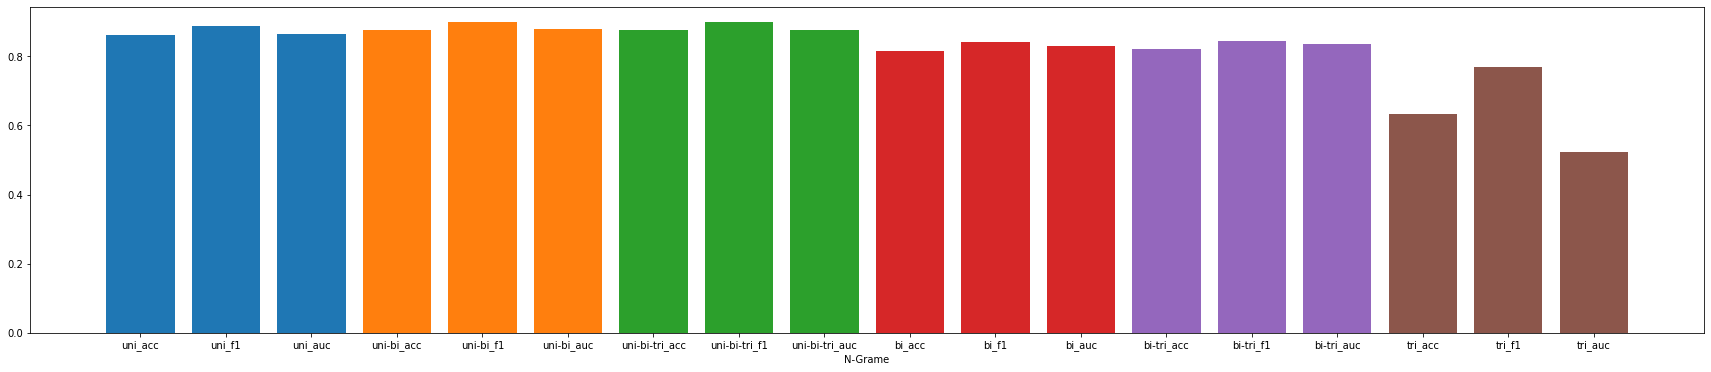

In [ ]:
ngrame = ["uni", "uni-bi","uni-bi-tri","bi","bi-tri","tri"]

fig = plt.figure(figsize=(30, 6))

for value in ngrame:
    acc_value = t_acc[ngrame.index(value)]
    f1_value = t_f1[ngrame.index(value)]
    auc_valeur = t_auc[ngrame.index(value)]

    plt.bar([value + "_acc", value + "_f1",value + "_auc"], [acc_value, f1_value, auc_valeur])
    
plt.xlabel("N-Grame")
plt.show()

Sur data test

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)

mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=100000,
                                binary=False)

mon_X = mon_vectorizer.fit_transform(corpus_traite)
X_test = mon_vectorizer.transform(corpus_traite_test)
sm = SMOTE(k_neighbors=3, sampling_strategy=0.6)

# Application du SMOTE aux données
X_res, lab_res = sm.fit_resample(mon_X, alllabs_president)

In [ ]:
#Logistic Regression
lr_clf.fit(X_res, lab_res)
y_hat = lr_clf.predict(X_test)
# M -1, C 1
with open("f_eval_lr__ubtgramme_smote.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


### Custom Vectorizer
Joueur avec des paramètres

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                            max_df=0.9, min_df=1,
                             max_features=None,
                             binary=False)
mon_X = mon_vectorizer.fit_transform(corpus_traite)
print("Taille du dictionnaire :", len(mon_vectorizer.get_feature_names_out()))

ros = RandomOverSampler(sampling_strategy=1) # minor = maj, incrementer minor
X_res, lab_res = ros.fit_resample(mon_X, alllabs_president)

custom_tab_clf_nom = ["Logistic Regression"]

#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

custom_tab_clf = [lr_clf]
# CV
cv_kfold(X_res, lab_res,custom_tab_clf,custom_tab_clf_nom)

Taille du dictionnaire : 351988
Logistic Regression
Accuracy: 0.9629585087191822
F1 score: 0.9622595270187477
AUC: 0.9631785241005122


Faire varier max_df et max_feature, cela prendra du temps

In [ ]:
t_mdf = [0.7, 0.8, 0.9, 1.]
t_maxfeature = [100000, 200000, 300000, 351988] # max 351988 = taille dict bigramme
res = np.zeros((len(t_maxfeature),len(t_mdf),3)) # 3 = nombre de score metrics acc, f1, auc
start = time.time()
for i in range(len(t_maxfeature)):
  for j in range(len(t_mdf)):
    mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                max_df=t_mdf[j], min_df=1,
                                max_features=t_maxfeature[i],
                                binary=False)
    mon_X = mon_vectorizer.fit_transform(corpus_traite)

    ros = RandomOverSampler(sampling_strategy=1) # minor = maj, incrementer minor
    X_res, lab_res = ros.fit_resample(mon_X, alllabs_president)

    custom_tab_clf_nom = ["Logistic Regression"]

    #Naïve Bayes
    nb_clf = MultinomialNB()
    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

    custom_tab_clf = [lr_clf]
    # CV
    res_cv = cv_kfold(X_res, lab_res,custom_tab_clf,custom_tab_clf_nom,affiche=False)

    res[i][j]=res_cv
end = time.time()
print("Temps d'exécution:", end-start)

Temps d'exécution: 1179.036529302597


In [ ]:
def plot3D(a1,a2,c,nom_a):
  # a1: 1er attribut, a2: 2eme attribut, c: tab des scores
  # 3D scatter plot 
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  dim = ["Accuracy", "F1-score", "AUC"]
  couleur = ["red", "blue", "green"]
  for k in range(c.shape[2]):
      for i in range(len(a1)):
          for j in range(len(a2)):
              x = a1[i]
              y = a2[j]
              z = c[i,j,k]
              ax.scatter(x, y, z, c=couleur[k])
      ax.scatter([], [], [], c=couleur[k], label=dim[k])  # lebel -> legend
  ax.set_xlabel(f'{nom_a[0]}')
  ax.set_ylabel(f'{nom_a[1]}')
  ax.set_zlabel('Scores')
  ax.legend()
  plt.show()

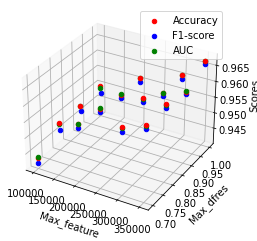

In [ ]:
plot3D(t_maxfeature,t_mdf,res,["Max_feature", "Max_dfres"])

**Remarque**</br>
Sur l'image, nous pouvons constater que avec max_feature = None et max_df = 1.0, nous obtenons les meilleures scores concernant Accuracy (qui est aussi important quand la distribution est indentique avec sampling), F1-Score et AUC.

Faire varier binaire est max_feature

In [ ]:
t_binaire = [False, True]
t_maxfeature = [100000, 200000, 300000, 351988] # max 351988 = taille dict bigramme
res = np.zeros((len(t_binaire),len(t_maxfeature),3)) # 3 = nombre de score metrics acc, f1, auc
start = time.time()
for i in range(len(t_binaire)):
  for j in range(len(t_maxfeature)):
    mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                max_df=1., min_df=1,
                                max_features=t_maxfeature[j],
                                binary=t_binaire[i])
    mon_X = mon_vectorizer.fit_transform(corpus_traite)

    ros = RandomOverSampler(sampling_strategy=1) # minor = maj, incrementer minor
    X_res, lab_res = ros.fit_resample(mon_X, alllabs_president)

    custom_tab_clf_nom = ["Logistic Regression"]

    #Naïve Bayes
    nb_clf = MultinomialNB()
    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 3000)
    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 3000)

    custom_tab_clf = [lr_clf]
    # CV
    res_cv = cv_kfold(X_res, lab_res,custom_tab_clf,custom_tab_clf_nom,affiche=False)

    res[i][j]=res_cv
end = time.time()
print("Temps d'exécution:", end-start)

Temps d'exécution: 579.4202315807343


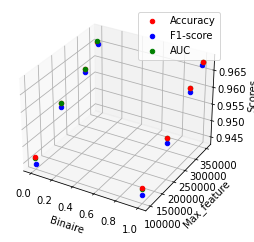

In [ ]:
plot3D(t_binaire,t_maxfeature,res,["Binaire", "Max_feature"])

**Remarque**</br>
Sur l'image, nous pouvons constater que avec Binary = True et max_feature = None, nous obtenons les meilleures scores concernant Accuracy (qui est aussi important quand la distribution est indentique avec sampling), F1-Score et AUC.

### Uni-bi-gramme sur data test

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)

mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                max_df=1., min_df=1,
                                max_features=None,
                                binary=True)

mon_X = mon_vectorizer.fit_transform(corpus_traite)
X_test = mon_vectorizer.transform(corpus_traite_test)
ros = RandomOverSampler(sampling_strategy=1) # minor = maj, incrementer minor
X_res, lab_res = ros.fit_resample(mon_X, alllabs_president)

In [ ]:
#Logistic Regression
lr_clf.fit(X_res, lab_res)
y_hat = lr_clf.predict(X_test)
# M -1, C 1
with open("f_eval_lr__ubgramme_oversampling.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


**Resultat**</br>
Nous obtenons f1-score: 56.5168, auc = 73.5886. Ce n'est pas très mauvais, f1-score a augmenté.

## Random Undersampling
Nous essayons de réduire le nombre d'exemple de la classe majoritaire

Counter({-1: 7523, 1: 7523})


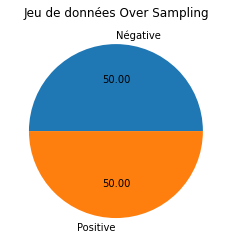

In [ ]:
rus = RandomUnderSampler(sampling_strategy=1) # minor = maj, reduire major
X_res, lab_res = rus.fit_resample(X, alllabs_president)

count = Counter(lab_res)
print(count)
nb_electif = np.array([count[-1], count[+1]])
plt.pie(nb_electif,labels=["Négative", "Positive"], autopct="%.2f")
plt.title("Jeu de données Over Sampling")
plt.show()

Testons avec split test

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X_res, lab_res, test_size=0.3, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)

# evaluation
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

Naïve Bayes
Accuracy: 0.7811253876827647
F1-score: 0.7745321770880876
Logistic Regression
Accuracy: 0.7540983606557377
F1-score: 0.7590099869735129


F1 score: 0.7745321770880876


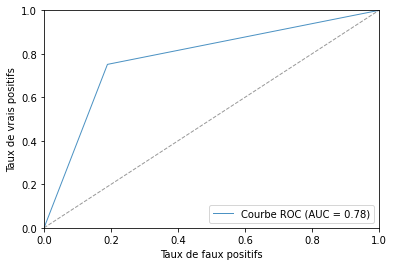

In [ ]:
# Naïve Bayes
ROC(y_test,y_pred_nb)

F1 score: 0.7590099869735129


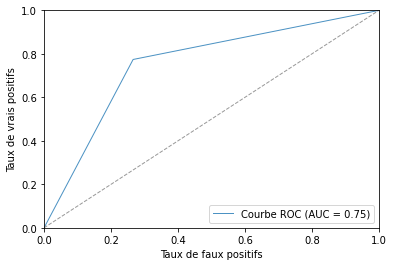

In [ ]:
# Logistic Regression
ROC(y_test,y_pred_lr)

Nous remarquons une augmentation pour ROC, AUC et F1-score par rapport au jeu de données initial mais une baisse par rapport à OverSampling.</br>
Nous testons sur les données test pour voir la différence.

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = vectorizer.transform(corpus_traite_test)

In [ ]:
#Logistic Regression
lr_clf.fit(X_res, lab_res)
y_hat = lr_clf.predict(X_test)
# M -1, C 1
with open("f_eval_lr_undersampling.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


### Résultat
Pour Logistic Regression, nous obtenons f1-score: 47.1424, auc: 75.4934</br>
Le résultat n'est pas aussi bon qu'avec Over Sampling, et F1-score est baissé encore plus bas.

## Utilisation de class-weight
Nous utilisons la pondération de classe, qui permet de pénaliser davantage les erreurs commises dans la classe minoritaire et peut aider à améliorer les performances de classification du modèle en augmentant sa capacité à identifier les exemples de la classe minoritaire.

### Balanced class weight

In [ ]:
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_lr_cw = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,class_weight='balanced',max_iter= 5000)
clf_svm_cw = LinearSVC(random_state=0, tol=1e-5,class_weight='balanced',max_iter= 5000)

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_president, test_size=0.3, random_state=42)

# training
clf_lr_cw.fit(Xapp_train, y_train)
clf_svm_cw.fit(Xapp_train, y_train)

# prediction
y_pred_lr = clf_lr_cw.predict(Xapp_test)
y_pred_svm = clf_svm_cw.predict(Xapp_test)

# evaluation
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))

Logistic Regression
Accuracy: 0.8264630747793776
F1-score: 0.8950528422457076
Linear SVM
Accuracy: 0.825243845796563
F1-score: 0.895107332032339


F1 score: 0.8950528422457076


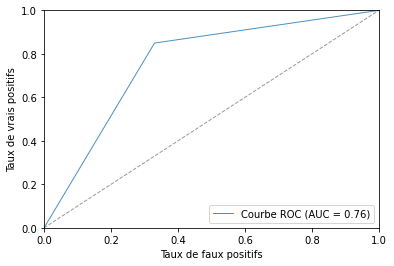

In [ ]:
# Logistic Regression
ROC(y_test,y_pred_lr)

F1 score: 0.895107332032339


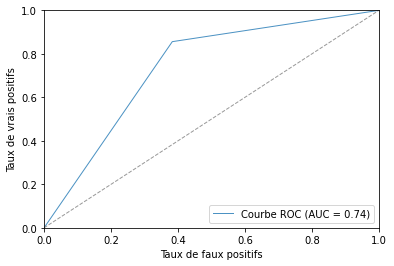

In [ ]:
# Linear SVM
ROC(y_test,y_pred_svm)

Nous utilisons la validation croissée pour trouver le meilleur parametre pour la pondération

### Grid_searche

In [ ]:
w = np.linspace(0.05, 0.95, 20)

grid_search_lr = GridSearchCV(estimator = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 5000),
                           param_grid={'class_weight': [{-1:x, 1:1.0-x} for x in w]},
                           scoring='f1', cv = 5)
res_grid_lr = grid_search_lr.fit(X, alllabs_president)
print("Meilleur pondération:", res_grid_lr.best_params_)

Meilleur pondération: {'class_weight': {-1: 0.4289473684210526, 1: 0.5710526315789475}}


### Test

Testons avec les données de test

#### Balanced

In [ ]:
corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = vectorizer.transform(corpus_traite_test)

In [ ]:
#Logistic Regression
clf_lr_cw_bl = LogisticRegression(random_state=0, solver='lbfgs',class_weight='balanced', n_jobs=-1,max_iter= 5000)
clf_lr_cw_bl.fit(X, alllabs_president)
y_hat = clf_lr_cw_bl.predict(X_test)
# M -1, C 1
with open("f_eval_lr_cw_balance.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


Nous obtenons f1-score: 51.6708, auc = 76.5385	</br>
La performance est aussi bonne que Sampling

#### Grid_search

In [ ]:
#Logistic Regression
clf_lr_cw = LogisticRegression(random_state=0, solver='lbfgs',**res_grid_lr.best_params_, n_jobs=-1,max_iter= 5000)
clf_lr_cw.fit(X, alllabs_president)
y_hat = clf_lr_cw.predict(X_test)
# M -1, C 1
with open("f_eval_lr_cw.txt", "w") as f:
  for pred in y_hat:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


Nous obtenons f1-score: 41.4578, auc = 63.4840</br>
La performance n'est pas aussi bonne comme nous avons attendu. Même nous avons utilisé grid_search pour trouver le paramètre optimal pour class-weight

<h2>Conclusion sur classe weight</h2>
Nous remarquons que mettre la pondération sur les classes aide à régler le déséquilibre dans la base de données. Mais comparé à Under Sampling et Over Sampling, le résultat est moins bon.</br>
Concernant les classifieurs, Logistics Regression fonctionne mieux que SVM dans cette modification.</br>
Par contre, utiliser le paramètre défaut "balanced" (ajuster les pondérations inversement proportionnelles aux fréquences de classe dans les données d'entrée) donne un meilleur résultat comparé à grid_search.


## Modification du biais

#### Uni-gramme

##### Validation croisée

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Split les données
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_president, test_size=0.2, random_state=42)

# Apprentissage du modèle
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)
clf_lr_biais.fit(Xapp_train, y_train)

# Faire la prediction et recuppérer le score de probabilité de la classe 1 - classe majoritaire
y_proba = clf_lr_biais.predict_proba(Xapp_test)[:, 1]

# Un plage de biais de -10 à 10 avec un pas de 0.1
biais_intervalle = np.arange(-1, 1, 0.1)

# Evaluer le modèle pour des valeurs de biais différentes
tab_accuracy = np.array([])
tab_f1 = np.array([])
tab_auc = np.array([])
tab_biais_valide = np.array([])

for biais in biais_intervalle:
    # y_hat = f(x) + b >= 0.5 
    y_pred = (y_proba + biais) >= 0.5
    y_pred = np.where(y_pred==True, 1, -1)

    # s'il y a qu'une seule classe
    cpt = Counter(y_pred)
    if cpt[-1] == len(y_pred) or cpt [1] == len(y_pred):
      continue
    # calculer les metriques d'évaluation
    acc = clf_lr_biais.score(Xapp_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Ajouter dans les tables
    tab_biais_valide = np.append(tab_biais_valide, biais)

    tab_accuracy = np.append(tab_accuracy, acc)
    tab_f1 = np.append(tab_f1, f1)
    tab_auc = np.append(tab_auc, roc_auc)
        

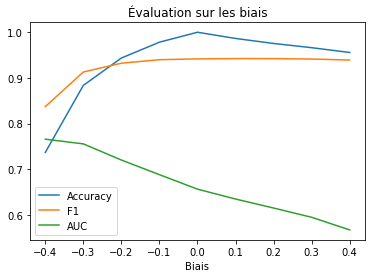

In [ ]:
plt.figure()
plt.plot(tab_biais_valide, tab_accuracy)
plt.plot(tab_biais_valide, tab_f1)
plt.plot(tab_biais_valide, tab_auc)

plt.xlabel("Biais")
plt.legend(["Accuracy", "F1", "AUC"])
plt.title("Évaluation sur les biais")
plt.show()

Il nous faut trouver un biais avec lequel le modèle a en même temps un bon F1-score, un bon AUC.</br>
Sur l'image, il semble que un biais de -0.3 et -0.2 sont de bons candidats. Mais -0.3 l'air plus prometteux concernant la compromise entre 3 valeurs métriques.

Accuracy 0.8836540973613167
F1 0.912947232947233
AUC 0.755550341653479


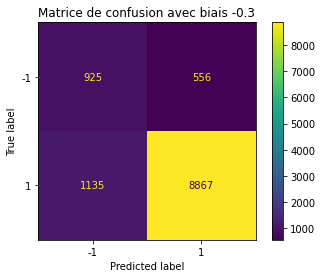

In [ ]:
best_biais = -0.3
y_pred_optimal = (y_proba + best_biais) >= 0.5
y_pred_optimal = np.where(y_pred_optimal==True, 1, -1)

print("Accuracy", clf_lr_biais.score(Xapp_test, y_pred_optimal))
print("F1",f1_score(y_test, y_pred_optimal))
fpr, tpr, _ = roc_curve(y_test, y_pred_optimal)
print("AUC",auc(fpr, tpr))
mc = confusion_matrix(y_test, y_pred_optimal, labels=clf_lr_biais.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=clf_lr_biais.classes_)
disp.plot()
plt.title("Matrice de confusion avec biais -0.3")
plt.show()

Accuracy 0.94356875380998
F1 0.9322328842042461
AUC 0.720175512500471


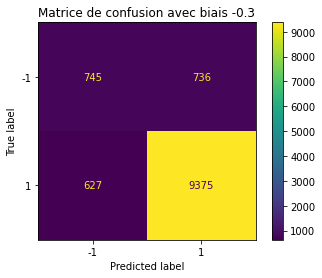

In [ ]:
best_biais = -0.2
y_pred_optimal = (y_proba + best_biais) >= 0.5
y_pred_optimal = np.where(y_pred_optimal==True, 1, -1)

print("Accuracy", clf_lr_biais.score(Xapp_test, y_pred_optimal))
print("F1",f1_score(y_test, y_pred_optimal))
fpr, tpr, _ = roc_curve(y_test, y_pred_optimal)
print("AUC",auc(fpr, tpr))
mc = confusion_matrix(y_test, y_pred_optimal, labels=clf_lr_biais.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=clf_lr_biais.classes_)
disp.plot()
plt.title("Matrice de confusion avec biais -0.2")
plt.show()

##### Application sur les données test

In [ ]:
fname_test = "./datasets/AFDpresidentutf8/corpus.tache1.test.utf8"
alltxts_president_test = load_pres_test(fname_test)

corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = vectorizer.transform(corpus_traite_test)

In [ ]:
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)
clf_lr_biais.fit(X, alllabs_president)

# reccuperer la probabilité pour classe 1 - classe majoritaire
y_proba = clf_lr_biais.predict_proba(X_test)[:, 1]

# rajouter le biais optimal trouvé
#best_biais = -0.2
best_biais = -0.3
y_pred_optimal = (y_proba + best_biais) >= 0.5
y_pred_optimal = np.where(y_pred_optimal==True, 1, -1)

# M -1, C 1
with open("f_eval_lr_biais_03.txt", "w") as f:
  for pred in y_pred_optimal:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


Pour biais -0.3, nous obtenons f1-score: 53.9811, auc = 75.8367</br>
Comme nous avons prévu, -0.3 fonctionne pas mal. Nous observons une augmentation de f1-score, l'auc n'est pas très mauvais.

### Uni-bi-gramme

##### Validation croisée

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                max_df=1., min_df=1,
                                max_features=None,
                                binary=True)

mon_X = mon_vectorizer.fit_transform(corpus_traite)

kf = KFold(n_splits=5, shuffle=True)
# modèle
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)

score_lr_kf = np.array([])
f1_lr_kf = np.array([])
auc_lr_kf = np.array([])
tab_biais_valide = np.array([])

# Un plage de biais de -10 à 10 avec un pas de 0.1
biais_intervalle = np.arange(-1, 1, 0.1)

for biais in biais_intervalle:
  biais_ok = True

  score_lr = np.array([])
  f1_lr = np.array([])
  auc_lr = np.array([])

  for train, test in kf.split(mon_X):
    X_train = mon_X[train]
    y_train = alllabs_president[train]
    Xapp_test  = mon_X[test]
    y_test  = alllabs_president[test]
    # training
    clf_lr_biais.fit(X_train, y_train)
    # Faire la prediction et recuppérer le score de probabilité de la classe 1 - classe majoritaire
    y_proba = clf_lr_biais.predict_proba(Xapp_test)[:, 1]

    # y_hat = f(x) + b >= 0.5 
    y_pred = (y_proba + biais) >= 0.5
    y_pred = np.where(y_pred==True, 1, -1)

    # s'il y a qu'une seule classe
    cpt = Counter(y_pred)
    if cpt[-1] == len(y_pred) or cpt [1] == len(y_pred):
      biais_ok = False
      break
    # calculer les metriques d'évaluation
    acc = clf_lr_biais.score(Xapp_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    score_lr = np.append(score_lr, acc)
    f1_lr = np.append(f1_lr, f1)
    auc_lr = np.append(auc_lr, roc_auc)

  if not biais_ok:
    continue
  tab_biais_valide = np.append(tab_biais_valide, biais)
  score_lr_kf = np.append(score_lr_kf, score_lr.mean())
  f1_lr_kf = np.append(f1_lr_kf, f1_lr.mean())
  auc_lr_kf = np.append(auc_lr_kf, auc_lr.mean())


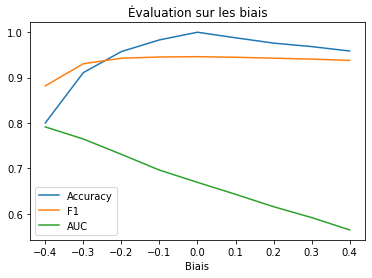

In [ ]:
plt.figure()
plt.plot(tab_biais_valide, score_lr_kf)
plt.plot(tab_biais_valide, f1_lr_kf)
plt.plot(tab_biais_valide, auc_lr_kf)

plt.xlabel("Biais")
plt.legend(["Accuracy", "F1", "AUC"])
plt.title("Évaluation sur les biais")
plt.show()

Encore une fois, nous observons qu'avec un biais de -0.3, il nous semble donner un meilleur résultat.

##### Application sur les données test

In [ ]:
fname_test = "./datasets/AFDpresidentutf8/corpus.tache1.test.utf8"
alltxts_president_test = load_pres_test(fname_test)

mon_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                max_df=1., min_df=1,
                                max_features=None,
                                binary=True)

mon_X = mon_vectorizer.fit_transform(corpus_traite)

corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = mon_vectorizer.transform(corpus_traite_test)

In [ ]:
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)
clf_lr_biais.fit(mon_X, alllabs_president)

# reccuperer la probabilité pour classe 1 - classe majoritaire
y_proba = clf_lr_biais.predict_proba(X_test)[:, 1]

# rajouter le biais optimal trouvé

best_biais = -0.3
y_pred_optimal = (y_proba + best_biais) >= 0.5
y_pred_optimal = np.where(y_pred_optimal==True, 1, -1)

# M -1, C 1
with open("f_eval_lr_ubg_biais_03.txt", "w") as f:
  for pred in y_pred_optimal:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


**Résultat**
Nous obtenons f1:57.7151, auc:76.2075.</br>
C'est le meilleur f1-score obtenu jusqu'à maintenant parmi les méthodes différentes pour rendre équilibré la base de données.

### Uni-bi-tri-gramme

##### Validation croisée

In [ ]:
mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=None,
                                binary=True)

mon_X = mon_vectorizer.fit_transform(corpus_traite)

kf = KFold(n_splits=5, shuffle=True)
# modèle
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)

score_lr_kf = np.array([])
f1_lr_kf = np.array([])
auc_lr_kf = np.array([])
tab_biais_valide = np.array([])

# Un plage de biais de -10 à 10 avec un pas de 0.1
biais_intervalle = np.arange(-1, 1, 0.1)

for biais in biais_intervalle:
  biais_ok = True

  score_lr = np.array([])
  f1_lr = np.array([])
  auc_lr = np.array([])

  for train, test in kf.split(mon_X):
    X_train = mon_X[train]
    y_train = alllabs_president[train]
    Xapp_test  = mon_X[test]
    y_test  = alllabs_president[test]
    # training
    clf_lr_biais.fit(X_train, y_train)
    # Faire la prediction et recuppérer le score de probabilité de la classe 1 - classe majoritaire
    y_proba = clf_lr_biais.predict_proba(Xapp_test)[:, 1]

    # y_hat = f(x) + b >= 0.5 
    y_pred = (y_proba + biais) >= 0.5
    y_pred = np.where(y_pred==True, 1, -1)

    # s'il y a qu'une seule classe
    cpt = Counter(y_pred)
    if cpt[-1] == len(y_pred) or cpt [1] == len(y_pred):
      biais_ok = False
      break
    # calculer les metriques d'évaluation
    acc = clf_lr_biais.score(Xapp_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    score_lr = np.append(score_lr, acc)
    f1_lr = np.append(f1_lr, f1)
    auc_lr = np.append(auc_lr, roc_auc)

  if not biais_ok:
    continue
  tab_biais_valide = np.append(tab_biais_valide, biais)
  score_lr_kf = np.append(score_lr_kf, score_lr.mean())
  f1_lr_kf = np.append(f1_lr_kf, f1_lr.mean())
  auc_lr_kf = np.append(auc_lr_kf, auc_lr.mean())


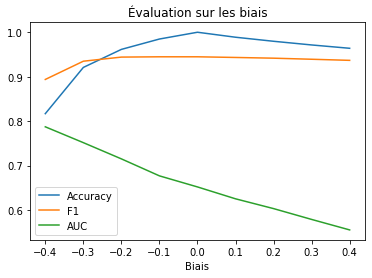

In [ ]:
plt.figure()
plt.plot(tab_biais_valide, score_lr_kf)
plt.plot(tab_biais_valide, f1_lr_kf)
plt.plot(tab_biais_valide, auc_lr_kf)

plt.xlabel("Biais")
plt.legend(["Accuracy", "F1", "AUC"])
plt.title("Évaluation sur les biais")
plt.show()

Il nous semble que -0.4 et -0.3 sont les meilleurs condidats.

##### Application sur les données test

In [ ]:
fname_test = "./datasets/AFDpresidentutf8/corpus.tache1.test.utf8"
alltxts_president_test = load_pres_test(fname_test)

mon_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                max_df=1., min_df=1,
                                max_features=None,
                                binary=True)

mon_X = mon_vectorizer.fit_transform(corpus_traite)

corpus_traite_test=prepretraiter_corpus(alltxts_president_test,stop_word = stopwords_fr, stem=stemmer)
X_test = mon_vectorizer.transform(corpus_traite_test)

In [ ]:
clf_lr_biais = LogisticRegression(random_state=42,solver='lbfgs',n_jobs=-1,max_iter= 3000)
clf_lr_biais.fit(mon_X, alllabs_president)

# reccuperer la probabilité pour classe 1 - classe majoritaire
y_proba = clf_lr_biais.predict_proba(X_test)[:, 1]

# rajouter le biais optimal trouvé

best_biais = -0.3
#best_biais = -0.4
y_pred_optimal = (y_proba + best_biais) >= 0.5
y_pred_optimal = np.where(y_pred_optimal==True, 1, -1)

# M -1, C 1
with open("f_eval_lr_ubtg_biais_03.txt", "w") as f:
  for pred in y_pred_optimal:
        if pred == -1:
          f.write("M\n")
        else:
          f.write("C\n")
  print('Done')

Done


## Conclusion sur la dataset reconnaissance du locuteur (Chirac/Mitterrand)
Une base de données déséquilibrée donne une mauvais généralisation. Nous avons testé 3 méthodes différentes pour régler ce problème, et 2 parmi 3 (OverSampling et Modification de biais) donnent une augmentation pour la performance.</br>
Il faut raconter aussi des variation différentes qui aident à amélirorer la performance, tel que n-gramme, binary. Par contre, le taille du dictionnaire incrémente exponentiellement avec n-gramme, et cela pose un vrai soucis pour la validation croissée pour trouver de bons hyperparamètres afin d'obtenir une meilleure performance.</br>

# Classification de sentiments (films)

In [49]:
path = "./datasets/movies/movies1000/"

alltxts_film,alllabs_film = load_movies(path)
alllabs_film = np.asarray(alllabs_film)

## Pré-traiter les données

Nous regardons la distribution des classes

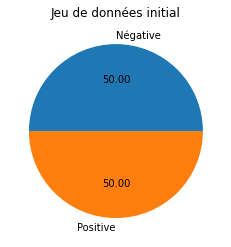

In [50]:
count = Counter(alllabs_film)
nb_electif = np.array([count[0], count[+1]])
plt.pie(nb_electif,labels=["Négative", "Positive"], autopct="%.2f")
plt.title("Jeu de données initial")
plt.show()

In [51]:
def prepretraiter_corpus_film(corpus, extraire=None,lower=True, ponctuation=True, stop_word = None, enleve_accent=True, marqueur=True, sup_chiffre=True, stem=None):
  corpus_res = []
  for doc in corpus:
    if extraire is not None:
      if extraire == 0: #garder que la premiere ligne
        doc = [sentence for sentence in doc.split("\n") if sentence != ''][0]
      elif extraire == 1: #garder que la derniere ligne
        doc = [sentence for sentence in doc.split("\n") if sentence != ''][-1]
    if lower:
      doc=doc.lower()
    if ponctuation:
      punc = string.punctuation + '\n\r\t'
      doc = doc.translate(str.maketrans(punc, ' '*len(punc)))
    if marqueur:
      doc = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', doc)
    if sup_chiffre:
      doc = re.sub('[0-9]+', '', doc)
    if stop_word is not None:
      doc = word_tokenize(doc)
      doc = ' '.join([w for w in doc if w not in stop_word])
    if enleve_accent:
      doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
    if stem is not None:
      doc = word_tokenize(doc)
      doc = ' '.join([stem.stem(w) for w in doc])
    corpus_res.append(doc)
  return corpus_res

Tester la fonctionnalité du paramètre extraire

In [ ]:
test = alltxts_film[0]
prepretraiter_corpus_film([test], extraire=0)

['maybe this mission should have been scrubbed ']

In [ ]:
test = alltxts_film[0]
prepretraiter_corpus_film([test], extraire=1)

['they should save the commercials for those insipid bits before the film   ']

### Première vue sur les données

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)
vectorizer = CountVectorizer(max_df=1.,min_df=1,max_features=None)

X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 24812


In [ ]:
## N-gram
tab_nom_ = ["Uni et bi-gram", "bi-gram", "tri-gram","uni-bi-tri-gram"]
tab_ngram = [(1,2), (2,2), (3,3),(1,3)]
tab_X_ngram = []
tab_vec_ngram = []
# creation 
for choix in tab_ngram:
  vectorizer_ngram = CountVectorizer(ngram_range=choix)
  X_ngram = vectorizer_ngram.fit_transform(corpus_film_traite)
  # ajoutation
  tab_vec_ngram.append(vectorizer_ngram)
  tab_X_ngram.append(X_ngram)
for i in range(len(tab_nom_)):
  print(f"Taille du dictionnaire pour {tab_nom_[i]} :", len(tab_vec_ngram[i].get_feature_names_out()))

Taille du dictionnaire pour Uni et bi-gram : 506106
Taille du dictionnaire pour bi-gram : 481294
Taille du dictionnaire pour tri-gram : 671722
Taille du dictionnaire pour uni-bi-tri-gram : 1177828


Distribution des mots

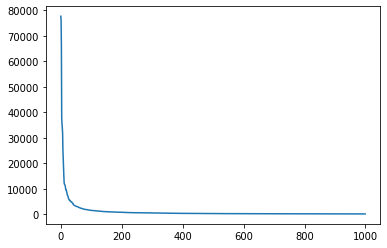

In [ ]:
stopwords_en = stopwords.words('english')
corpus = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en)
corpus = ''.join(alltxts_film)
word = corpus.split()
cpt = Counter(word)
nb_occ = [f for w,f in cpt.most_common(1000)]
plt.plot(nb_occ)

Nous voyons que la distribution suit bien la loi de Zipf</br>
Nous allons visualiser les données avec WordCloud

(-0.5, 399.5, 199.5, -0.5)

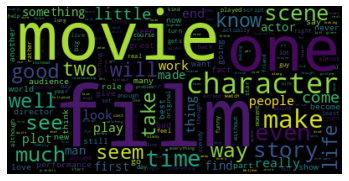

In [ ]:
from wordcloud import WordCloud

corpus = ''.join(alltxts_film)

wordcloud = WordCloud().generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Nous affichons les 100 mots les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

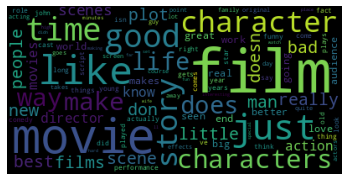

In [ ]:
vectorizer_tmp = CountVectorizer(max_df=0.95, stop_words='english')
X = vectorizer_tmp.fit_transform(alltxts_film)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Les 100 mots dont la fréquence documentaire est la plus grande

(-0.5, 399.5, 199.5, -0.5)

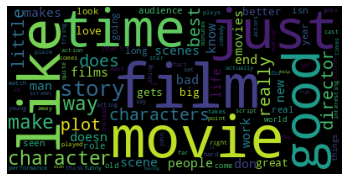

In [ ]:
vectorizer_tmp = CountVectorizer(max_df=0.95, stop_words='english',binary=True) # binary = True, on met 1 au lieu du nombre d'occurence
X = vectorizer_tmp.fit_transform(alltxts_film)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Nous affichons les 100 bi-gramme les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

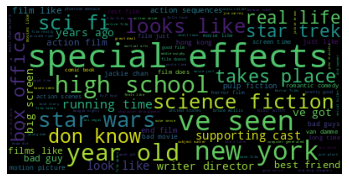

In [ ]:
vectorizer_tmp = CountVectorizer(ngram_range=(2,2),max_df=0.95, stop_words='english')
X = vectorizer_tmp.fit_transform(alltxts_film)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

Et les 100 tri-gramme les plus fréquents

(-0.5, 399.5, 199.5, -0.5)

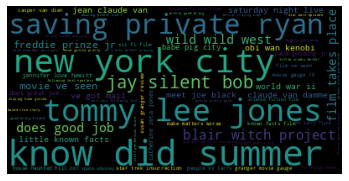

In [ ]:
vectorizer_tmp = CountVectorizer(ngram_range=(3,3),max_df=0.95, stop_words='english')
X = vectorizer_tmp.fit_transform(alltxts_film)
freq = X.toarray().sum(0)
dic_freq = dict(zip(vectorizer_tmp.get_feature_names_out(), freq))
fd_plusgrand = sorted(dic_freq.items(), key=lambda x: x[1], reverse=True)[:100]
wc = WordCloud().generate_from_frequencies(dict(fd_plusgrand))
plt.figure()
plt.imshow(wc)
plt.axis("off")

## Apprentissage

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

tab_clf_nom = ["Naïve Bayes","Logistic Regression","Linear SVM" ]
#Naïve Bayes
nb_clf = MultinomialNB()
#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 5000)
#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 5000)

tab_clf = [nb_clf, lr_clf,svm_clf]

### Uni-gramme

#### Data sans modification

In [56]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 24812


##### KFold

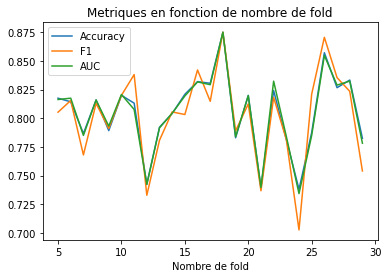

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split test

In [57]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

In [62]:
features = {v:k for k,v in vectorizer.vocabulary_.items()}
#Naïve bayes

k = 10

feat_neg = nb_clf.feature_log_prob_[0] # liste de log probabilité pour classe 0
feat_pos = nb_clf.feature_log_prob_[1]# liste de log probabilité pour classe 1

most_neg = [features[i] for i in feat_neg.argsort()[::-1]] 
most_pos = [features[i] for i in feat_pos.argsort()[::-1]]

print(most_neg[:k])
print(most_pos[:k])

['film', 'movi', 'one', 'like', 'charact', 'get', 'make', 'even', 'time', 'scene']
['film', 'one', 'movi', 'like', 'charact', 'make', 'time', 'get', 'stori', 'scene']


In [60]:
features = {v:k for k,v in vectorizer.vocabulary_.items()}
#Logistic Regression
k = 10 # nb de mots
feat = lr_clf.coef_[0]
most_neg = [features[i] for i in feat.argsort()]
most_pos = [features[i] for i in feat.argsort()[::-1]]
print("NEG")
print(most_neg[:k])
print("POS")
print(most_pos[:k])

NEG
['bad', 'suppos', 'wast', 'bore', 'poor', 'worst', 'unfortun', 'noth', 'attempt', 'guess']
POS
['fun', 'perfect', 'great', 'enjoy', 'entertain', 'see', 'matrix', 'carri', 'well', 'other']


In [61]:
#SVM
k = 10
feat = svm_clf.coef_[0]
most_neg = [features[i] for i in feat.argsort()]
most_pos = [features[i] for i in feat.argsort()[::-1]]
print("NEG")
print(most_neg[:k])
print("POS")
print(most_pos[:k])

NEG
['wast', 'horrend', 'extraordinarili', 'suppos', 'poor', 'worst', 'bad', 'bore', 'unfortun', 'anyway']
POS
['fun', 'perfect', 'enjoy', 'great', 'matrix', 'carri', 'local', 'entertain', 'see', 'memor']


Naïve Bayes
Accuracy: 0.8075
F1 score: 0.8020565552699229


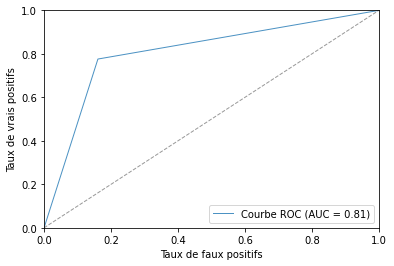

Logistic Regression
Accuracy: 0.8525
F1 score: 0.8557457212713937


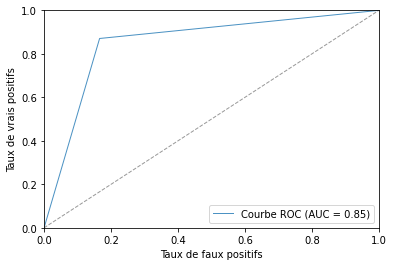

Linear SVM
Accuracy: 0.84
F1 score: 0.8439024390243902


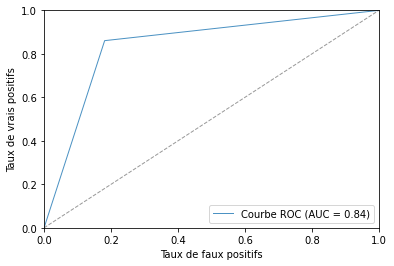

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Data conservé que titre

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,extraire=0,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 5854


##### KFold

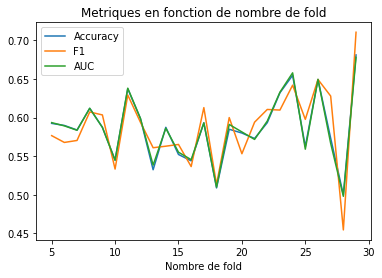

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split test

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.55
F1 score: 0.5544554455445545


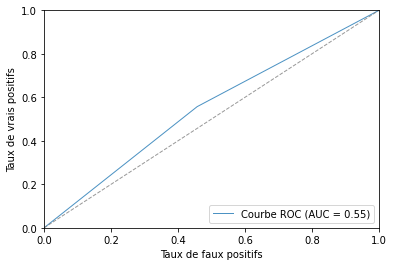

Logistic Regression
Accuracy: 0.5575
F1 score: 0.5607940446650124


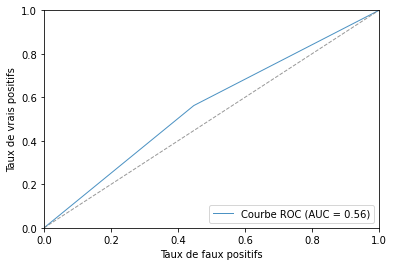

Linear SVM
Accuracy: 0.565
F1 score: 0.5515463917525772


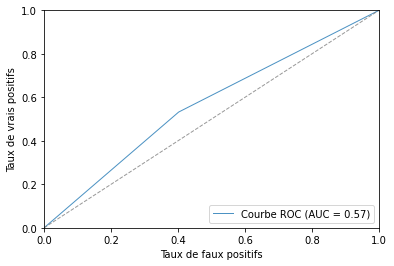

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

Le résultat n'est pas aussi bon que l'apprentissage avec les documents entiers. Les 3 scores sont très faible.

#### Data conservé que résumé

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,extraire=1,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 4396


##### FKold

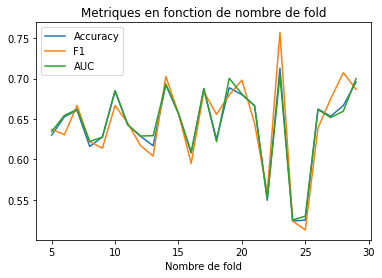

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split Test

In [ ]:
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.6525
F1 score: 0.6601466992665037


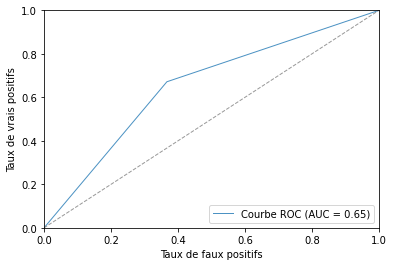

Logistic Regression
Accuracy: 0.63
F1 score: 0.6224489795918368


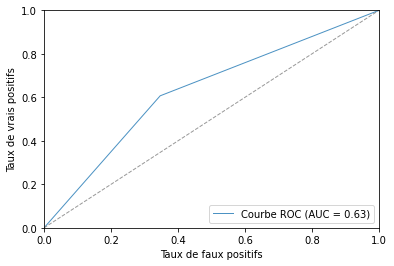

Linear SVM
Accuracy: 0.6275
F1 score: 0.6302729528535981


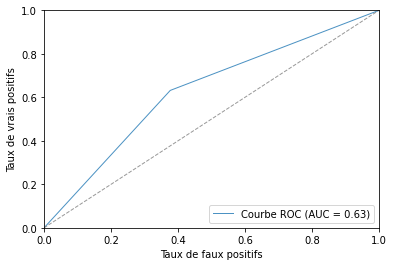

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Remarque
En utilisant uni_gramme la performance n'est pas très bonne. Les 3 scores sont très faible.</br>
En plus, les informations récues parmis les résumés semblent meilleures que dans les titre, comparé aux données entières, c'est moins bonnne mais plus rapide.

### Uni-bigramme

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(ngram_range=(1, 2),max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 506106


#### Data sans modification

##### KFold

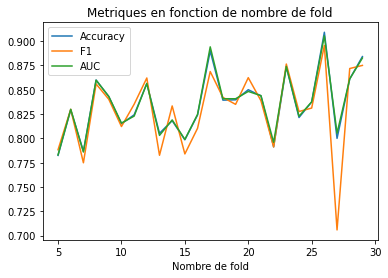

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split test

In [ ]:
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 7000)
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.8325
F1 score: 0.8329177057356607


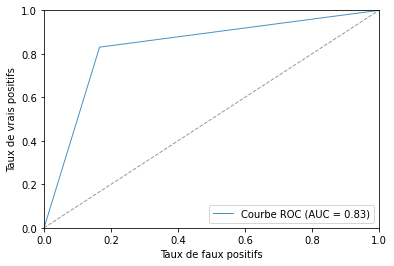

Logistic Regression
Accuracy: 0.8575
F1 score: 0.8585607940446649


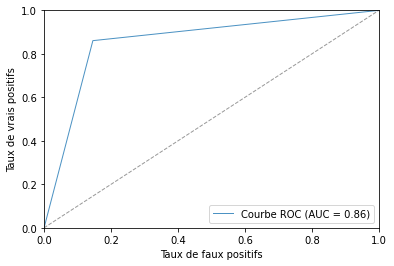

Linear SVM
Accuracy: 0.85
F1 score: 0.8536585365853658


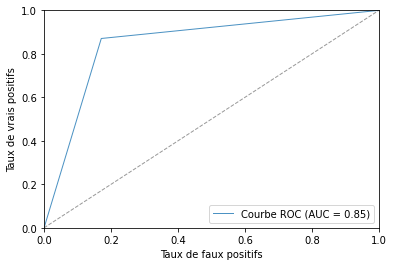

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Data conservé que titre

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,extraire=0,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(ngram_range=(1, 2),max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 25003


##### KFold

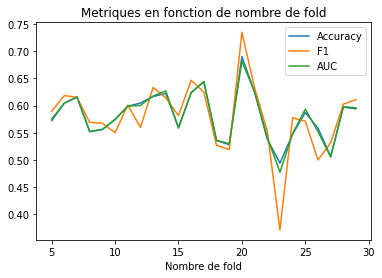

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split test

In [ ]:
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 7000)
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.5725
F1 score: 0.5819070904645477


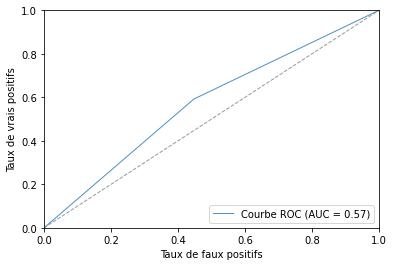

Logistic Regression
Accuracy: 0.5575
F1 score: 0.5426356589147286


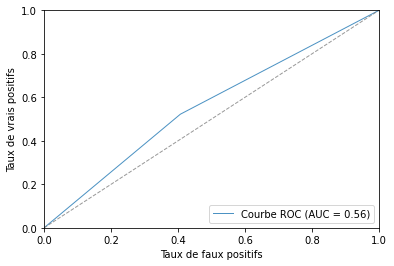

Linear SVM
Accuracy: 0.5575
F1 score: 0.5305039787798409


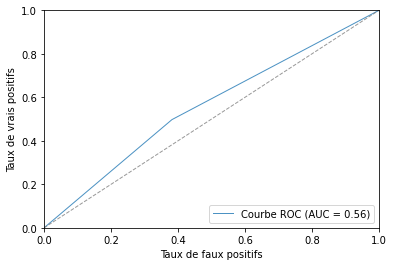

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Data conservé que résumé

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,extraire=1,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(ngram_range=(1, 2),max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 18573


##### KFold

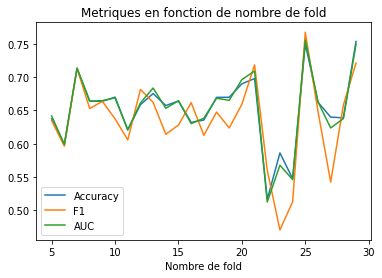

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

##### Split test

In [ ]:
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 7000)
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.6675
F1 score: 0.6649874055415617


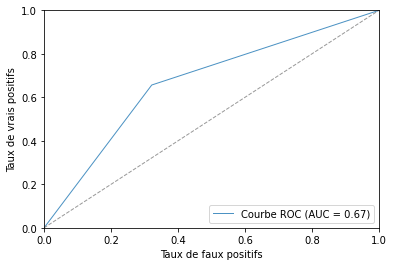

Logistic Regression
Accuracy: 0.66
F1 score: 0.6476683937823834


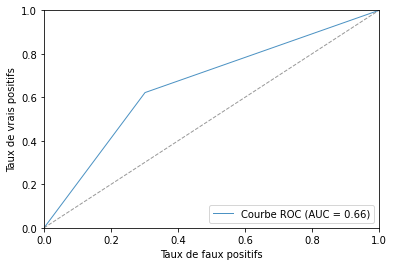

Linear SVM
Accuracy: 0.6075
F1 score: 0.6045340050377834


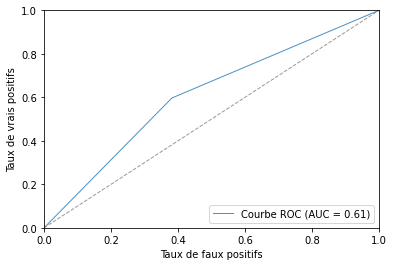

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Remarque
En utilisant, uni_bi-gramme, la performance devient meilleur. Par contre, le temps d'éxécution augmente à cause de la taille du dictionnaire.</br>
En plus, les informations récues parmis les résumés semblent meilleures que dans les titre, comparé aux données entières, c'est moins bonnne mais plus rapide.

### Uni-bi-tri-gramme - TF-IDF

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=0.95,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 1177828


#### KFold

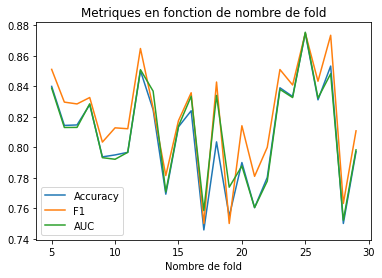

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

#### Split test

In [ ]:
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 7000)
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.82
F1 score: 0.8285714285714286


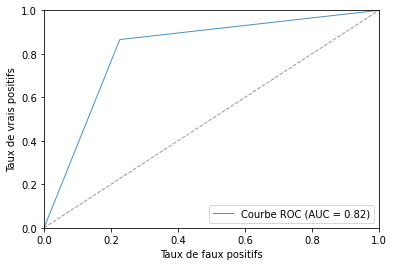

Logistic Regression
Accuracy: 0.83
F1 score: 0.8291457286432161


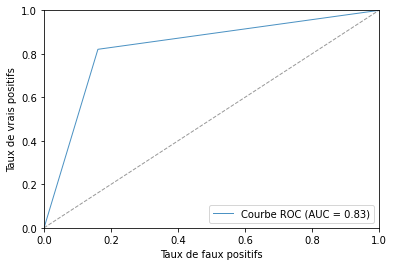

Linear SVM
Accuracy: 0.8375
F1 score: 0.8387096774193548


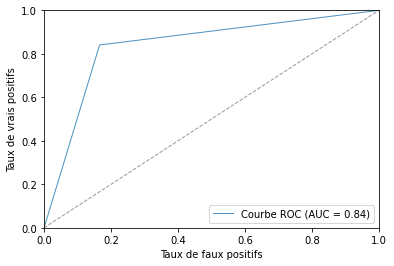

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

### Uni-bi-tri-gramme - TF-IDF - SubLinear

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=0.95,min_df=1,max_features=None,sublinear_tf=True)
X = vectorizer.fit_transform(corpus_film_traite)
dic_size = X.shape[1]
print("Taille du dictionnaire:",dic_size)

Taille du dictionnaire: 1177828


#### KFold

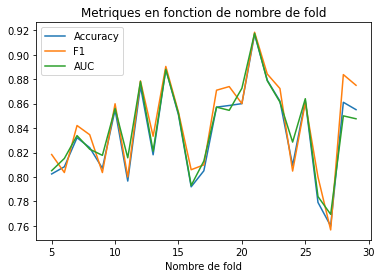

In [ ]:
t_k = [i for i in range(5,30)]
accucary = np.array([])
f1 = np.array([])
auc_score = np.array([])
for k in t_k:
  res = cv_kfold(X, alllabs_film, [nb_clf], ["Naïve Bayes"],nb_splits=k,affiche=False)
  accucary = np.append(accucary, res[0])
  f1 = np.append(f1, res[1])
  auc_score = np.append(auc_score, res[2])

plt.figure()
plt.plot(t_k, accucary)
plt.plot(t_k, f1)
plt.plot(t_k, auc_score)
plt.legend(["Accuracy", "F1","AUC"])
plt.xlabel('Nombre de fold')
plt.title('Metriques en fonction de nombre de fold')
plt.show()

#### Split test

In [ ]:
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter= 7000)
Xapp_train, Xapp_test, y_train, y_test = train_test_split(X, alllabs_film, test_size=0.2, random_state=42)

# training
nb_clf.fit(Xapp_train, y_train)
lr_clf.fit(Xapp_train, y_train)
svm_clf.fit(Xapp_train, y_train)

# prediction
y_pred_nb = nb_clf.predict(Xapp_test)
y_pred_lr = lr_clf.predict(Xapp_test)
y_pred_svm = svm_clf.predict(Xapp_test)

Naïve Bayes
Accuracy: 0.8275
F1 score: 0.8353221957040572


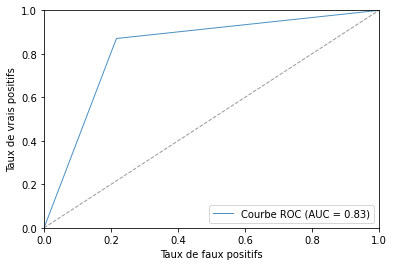

Logistic Regression
Accuracy: 0.835
F1 score: 0.8316326530612245


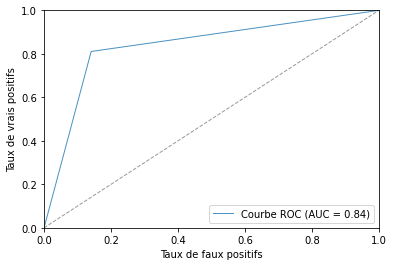

Linear SVM
Accuracy: 0.8575
F1 score: 0.85785536159601


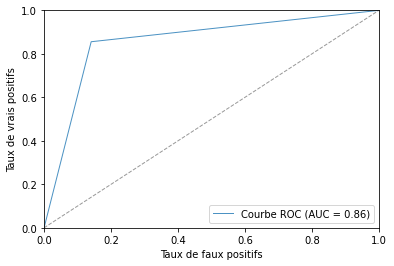

In [ ]:
print("Naïve Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
ROC(y_test,y_pred_nb)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
ROC(y_test,y_pred_lr)
print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
ROC(y_test,y_pred_svm)

#### Remarque
Malgré qu'une utilisation de combination de uni-gramme, bi-gramme et tri-gramme, nous n'avons pas pu améliorer la performance des modèles. Nous remarquons une petite augmentation sur SVM avec TF-IDF SubLinear mais c'est insignifiant.

### Grid Search

In [ ]:
path = "./datasets/movies/movies1000/"

alltxts_film,alllabs_film = load_movies(path)
alllabs_film = np.asarray(alllabs_film)

stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)


In [ ]:
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
f1_scorer = make_scorer(f1_score)
auc_scorer = make_scorer(roc_auc_score)

# Custom grid_search
max_f1 = -1
max_auc = -1
t_ngram = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
t_binaire = [False, True]
t_max_features=[2000, 5000, 10000]
t_max_df = [.7, .8, .9, 1.]
for ng in t_ngram:
  for b in t_binaire:
    for max_f in t_max_features:
      for max_df in t_max_df:
        vectorizer = CountVectorizer(ngram_range=ng,max_df=max_df,min_df=1,max_features=max_f,binary=b)
        X = vectorizer.fit_transform(corpus_film_traite)
        param_ = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]}

        grid_search_lr = GridSearchCV(estimator = LogisticRegression(random_state=0, solver='liblinear',max_iter= 10000),
                           param_grid=param_,
                           scoring={'f1': f1_scorer, 'auc': auc_scorer},refit='f1', cv = 5)
        grid_search_lr.fit(X, alllabs_film)

        if grid_search_lr.best_score_ > max_f1:
          max_f1 = grid_search_lr.best_score_
          # Print the best parameters and score
          print(f"N-gram:{ng}, Binary:{b}, Max_feature:{max_f}, max_df:{max_df}")
          print("Best parameters:", grid_search_lr.best_params_)
          print("Best score:", grid_search_lr.best_score_)

N-gram:(1, 1), Binary:False, Max_feature:2000, max_df:0.7
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.840554490852172
N-gram:(1, 1), Binary:False, Max_feature:2000, max_df:1.0
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.8413789322391828
N-gram:(1, 1), Binary:False, Max_feature:5000, max_df:0.7
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.8500776522413425
N-gram:(1, 1), Binary:False, Max_feature:5000, max_df:0.8
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.8523287344163991
N-gram:(1, 1), Binary:False, Max_feature:10000, max_df:0.7
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.852450429255569
N-gram:(1, 1), Binary:True, Max_feature:5000, max_df:0.7
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.854946637487048
N-gram:(1, 1), Binary:True, Max_feature:5000, max_df:0.8
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.8581043006817259
N-gram:(1, 1), Binary:True, Max_feature:10000, max_df:0.9
Best 

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

## Evaluation sur data test

In [ ]:
from sklearn.linear_model import LogisticRegression

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1,max_iter= 5000)

In [ ]:
path = "./datasets/movies/movies1000/"

alltxts_film,alllabs_film = load_movies(path)
alllabs_film = np.asarray(alllabs_film)

In [ ]:
def load_movies_test(fname): # 1 classe par répertoire
    alltxts = [] # init vide
    with open(fname, "r") as f:
      while True:
        txt = f.readline()
        if(len(txt))<5:
            break 
        alltxts.append(txt)  
    return alltxts

In [ ]:
txt_test = load_movies_test("./datasets/movies/testSentiment.txt")

In [ ]:
len(txt_test)

25000

### Uni-gram

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(max_df=1.,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
corpus_film_test_traite = prepretraiter_corpus_film(txt_test,stop_word = stopwords_en,stem=stemmer_en)
X_test = vectorizer.transform(corpus_film_test_traite)

In [ ]:
lr_clf.fit(X,alllabs_film)
y_hat = lr_clf.predict(X_test)
# neg 0, pos 1
with open("f_eval_film_lr_uni.txt", "w") as f:
  for pred in y_hat:
        if pred == 0:
          f.write("N\n")
        else:
          f.write("P\n")
  print('Done')

Done


### Uni-bi-gram

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=.9,min_df=1,max_features=None)
X = vectorizer.fit_transform(corpus_film_traite)
corpus_film_test_traite = prepretraiter_corpus_film(txt_test,stop_word = stopwords_en,stem=stemmer_en)
X_test = vectorizer.transform(corpus_film_test_traite)

In [ ]:
lr_clf.fit(X,alllabs_film)
y_hat = lr_clf.predict(X_test)
# neg 0, pos 1
with open("f_eval_film_lr_uni_bi.txt", "w") as f:
  for pred in y_hat:
        if pred == 0:
          f.write("N\n")
        else:
          f.write("P\n")
  print('Done')

Done


### Uni_bi_tri gramme - TF-IDF

All features

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=0.95,min_df=1,max_features=None,sublinear_tf=True)
X = vectorizer.fit_transform(corpus_film_traite)
corpus_film_test_traite = prepretraiter_corpus_film(txt_test,stop_word = stopwords_en,stem=stemmer_en)
X_test = vectorizer.transform(corpus_film_test_traite)

In [ ]:
lr_clf.fit(X,alllabs_film)
y_hat = lr_clf.predict(X_test)
# neg 0, pos 1
with open("f_eval_film_lr_ubt_idf.txt", "w") as f:
  for pred in y_hat:
        if pred == 0:
          f.write("N\n")
        else:
          f.write("P\n")
  print('Done')

Done


2000 features

In [ ]:
stopwords_en = stopwords.words('english')
stemmer_en = SnowballStemmer("english")
corpus_film_traite = prepretraiter_corpus_film(alltxts_film,stop_word = stopwords_en,stem=stemmer_en)

vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=0.95,min_df=1,max_features=2000,sublinear_tf=True)
X = vectorizer.fit_transform(corpus_film_traite)
corpus_film_test_traite = prepretraiter_corpus_film(txt_test,stop_word = stopwords_en,stem=stemmer_en)
X_test = vectorizer.transform(corpus_film_test_traite)

In [ ]:
lr_clf.fit(X,alllabs_film)
y_hat = lr_clf.predict(X_test)
# neg 0, pos 1
with open("f_eval_film_lr_ubt_2000_idf.txt", "w") as f:
  for pred in y_hat:
        if pred == 0:
          f.write("N\n")
        else:
          f.write("P\n")
  print('Done')

Done


## Conclusion sur la dataset classification de sentiments
Pour une base de données train limitée 2000 exemples, choisir le modèle ainsi que les modifications pose des problèmes.</br>
Avec les n-grammes différentes, nous constatons de performances différentes, mais le temps pour grid search quand nous avons beaucoup de hyper-paramètres est très couteux.</br>